# Neuron only analysis


Load in all the required packages

In [1]:
library(Seurat)
library(dplyr)
library(magrittr)
IRdisplay::display_html("<style> .container { width:95% !important; } </style>")
library("ggplot2")
library("xlsx")
library(tidyr)
library(cowplot)
library(svglite)
library(igraph)

Warning message:
"package 'Seurat' was built under R version 4.1.3"
Attaching SeuratObject

Attaching sp

Warning message:
"package 'dplyr' was built under R version 4.1.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'magrittr' was built under R version 4.1.3"


Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'xlsx' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.3"

Attaching package: 'tidyr'


The following object is masked from 'package:magrittr':

    extract


Warning message:
"package 'cowplot' was built under R version 4.1.3"
Warning message:
"package 'svglite' was built under R version 4.1.3"
Warning message:
"package 'igraph' was built under R version 4.1.3"

Attaching package: 'igraph'


The following object is masked from 'package:tidyr':

    crossing


The following objects are masked from 'package:dplyr':

    as_data_frame, groups, union


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




## Load in the data (stored as .rds files)

In [2]:
#VTA.integrated is the main seurat file that contains all information regarding group identity, cell cluster assignments and more
VTA.integrated<-readRDS(file="./VTA_integrated.rds")

In [3]:
#These .rds files are loading in the group data as separate variables in case we need to refer back to them for cell barcodes specifically belonging to each group
VTA_YFP <- readRDS(file = "./VTA_YFP.rds")
VTA_LH <- readRDS(file = "./VTA_LH.rds")
VTA_PFC <- readRDS(file = "./VTA_PFC.rds")
VTA_NAc <- readRDS(file = "./VTA_NAc.rds")

### Reassigning identities

When we first load in the .rds files, the cell cluster identites are unlabeled, or are denoted by a number instead of a real name (e.g. 0 instead of "Glu1"). This is so that everytime we load in the .rds, we can easily assign any names we want to 

In [4]:
#the table() function allows us to count the nubmer of cells in each Ident (cluster identity)
table(Idents(VTA.integrated))


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
1448  818  817  794  768  726  677  623  466  444  361  336  332  309  246  114 
  16 
  57 

In [5]:
sum(table(Idents(VTA.integrated)))

[1] 9336

In [6]:
#new.ident will redefine the cluster numbers to the labels below. With CoEx labels.
new.ident <- c("Glu1","CoEx1","Gaba1","DA1","DA2","Gaba2","Glu2","Glu3","Glu4","DA3","Glu5","Glu6","Glu7","CoEx2","CoEx3","Gaba3","Gaba4")
names(x = new.ident) <- levels(x =VTA.integrated)
VTA.integrated<- RenameIdents(object =VTA.integrated, new.ident)

In [7]:
#calling table(Ident()) again will tabulate the number of cells under their new names. The # of cells should be exactly the same as the last time you called table(Ident())
table(Idents(VTA.integrated))


 Glu1 CoEx1 Gaba1   DA1   DA2 Gaba2  Glu2  Glu3  Glu4   DA3  Glu5  Glu6  Glu7 
 1448   818   817   794   768   726   677   623   466   444   361   336   332 
CoEx2 CoEx3 Gaba3 Gaba4 
  309   246   114    57 

This for loop below adds each stim group name to the end of "barcode" for every cell, such that cells belonging to the YFP group will be labeled with "_barcode_VTA_YFP" and so on...Notice how we are now referencing the VTA_YFP variable for the barcodes

In [8]:
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(VTA.integrated@assays$RNA@data[,which(Idents(object=VTA.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
assign(paste(new.ident[i],"_barcode_VTA_YFP",sep=""),intersect(colnames(VTA_YFP@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_LH",sep=""),intersect(colnames(VTA_LH@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_NAc",sep=""),intersect(colnames(VTA_NAc@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
assign(paste(new.ident[i],"_barcode_VTA_PFC",sep=""),intersect(colnames(VTA_PFC@assays$RNA@data),eval(parse(text = paste(new.ident[i],"_barcode",sep="")))))
}

Here is code that we can use to visualize cell clusters

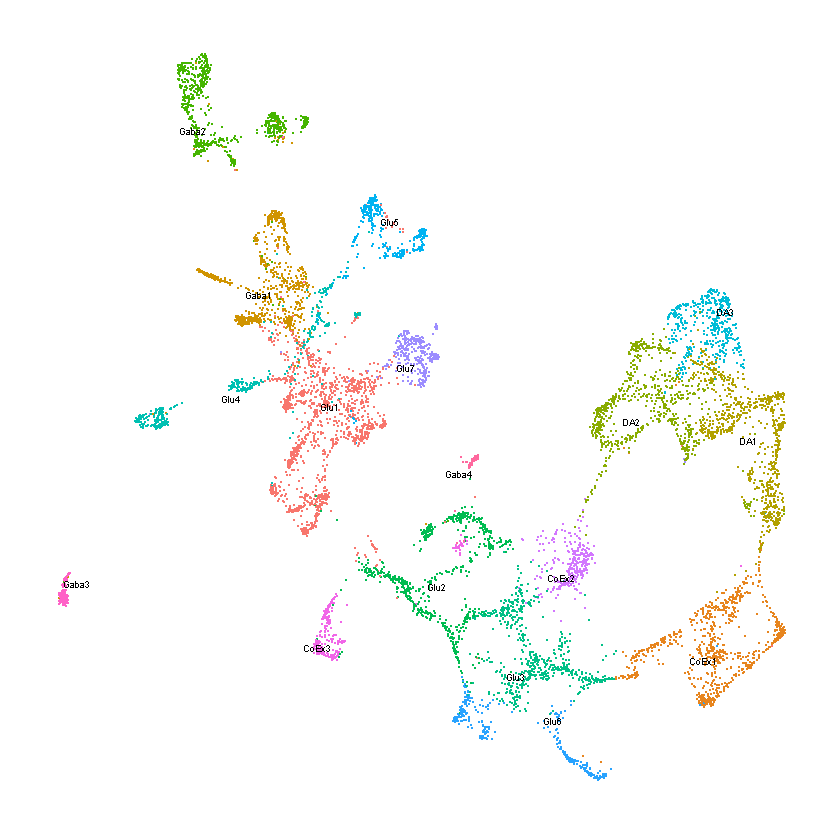

In [9]:
# Nicer formatting, can also highlight specific cells with commented out line
DimPlot(object = VTA.integrated, reduction = "umap", label = TRUE, repel = TRUE, pt.size = 0.10, label.size=2, 
      # sizes.highlight = 0.2, cells.highlight=c(DA1_barcode,DA2_barcode,DA3_barcode), cols.highlight="red"
       ) + 
theme_classic() + 
NoLegend() + 
theme(axis.line=element_blank(),
     axis.text=element_blank(),
     axis.title=element_blank(),
     axis.ticks=element_blank())


Now we want to insert into the meta.data what cluster each cell belongs to

In [10]:
barcode_names <- unique(paste(Idents(VTA.integrated),"_barcode",sep=""))

In [11]:
celltype<-vector()
for (i in 1:dim(VTA.integrated@meta.data)[1]){
    celltype[i]<-toString(new.ident[VTA.integrated@meta.data$integrated_snn_res.0.5[i]])
}
VTA.integrated@meta.data$celltype<-celltype

In [12]:
#There should now be a column "celltype" that tells us which group each row (cell) belongs to
VTA.integrated@meta.data

,orig.ident,nCount_RNA,nFeature_RNA,stim,percent.mito,integrated_snn_res.0.5,seurat_clusters,celltype
,<chr>,<dbl>,<int>,<chr>,<dbl>,<fct>,<fct>,<chr>
TTCTAGTTCAATCTTCVTA_YFP,VTA_input,15753,4972,VTA_YFP,0.0009521996,4,4,DA2
AAAGGGCGTACCTAACVTA_YFP,VTA_input,8664,3674,VTA_YFP,0.0010387812,8,8,Glu4
AAAGGGCTCAATCTCTVTA_YFP,VTA_input,8986,3520,VTA_YFP,0.0075673270,12,12,Glu7
AAAGTCCAGTCATCCAVTA_YFP,VTA_input,14770,4692,VTA_YFP,0.0008124577,0,0,Glu1
AAATGGAGTGAACGGTVTA_YFP,VTA_input,8646,3712,VTA_YFP,0.0019662272,0,0,Glu1
AAATGGAGTTCGTACAVTA_YFP,VTA_input,7236,3289,VTA_YFP,0.0012437811,0,0,Glu1
AACAAAGAGGAACATTVTA_YFP,VTA_input,10127,3776,VTA_YFP,0.0021724104,10,10,Glu5
AACAACCGTTGGTGTTVTA_YFP,VTA_input,12900,4507,VTA_YFP,0.0013953488,0,0,Glu1
AACACACAGAGTGTTAVTA_YFP,VTA_input,8018,3323,VTA_YFP,0.0012471938,0,0,Glu1


Generating cluster tree to evaluate relationship of cell clusters to one another

In [13]:
#To generate a cluster tree, we need to switch the "mode" of the data to "integrated". By default, seurat assumes to use the normalized counts (@assays$data), but for the cluster tree, we want
#to use the integrated dataframe to more clearly see the relationship of each cluster to one another
DefaultAssay(VTA.integrated) <- "integrated"

In [14]:
#pdf(file="./Output/cluster_tree_revised.pdf",width=10,height=4) 
VTA.integrated <- BuildClusterTree(VTA.integrated, verbose = FALSE, reorder = FALSE)
#PlotClusterTree(VTA.integrated)
#dev.off()

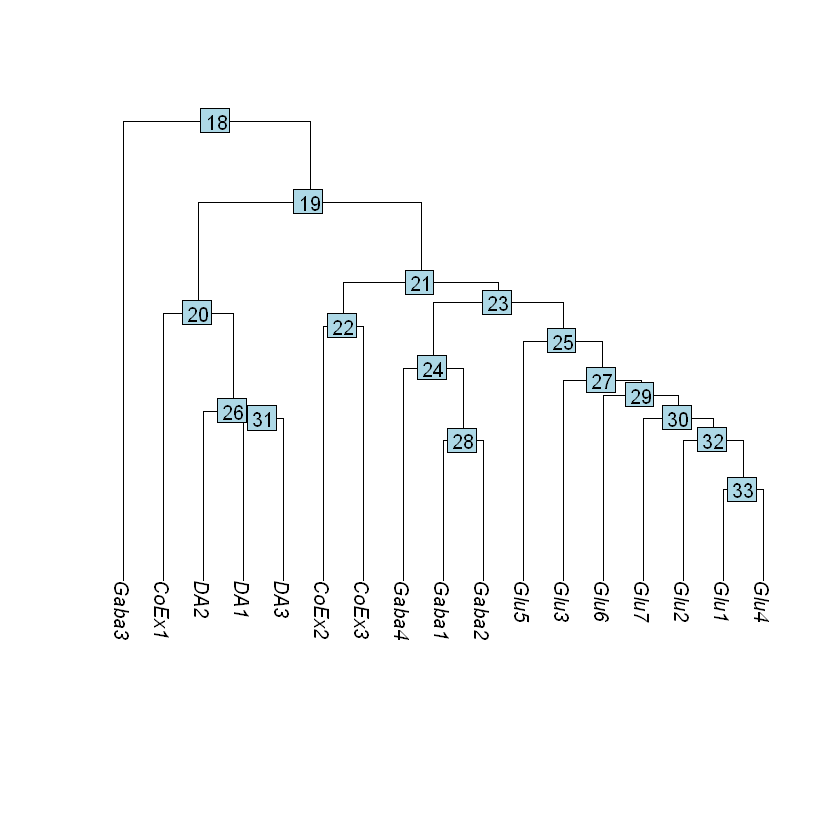

In [15]:
PlotClusterTree(VTA.integrated)

### Feature plots

In [16]:
#We need to switch back to RNA to see the true RNA expression levels in order to accurately visiualize them in space
DefaultAssay(VTA.integrated) <- "RNA"

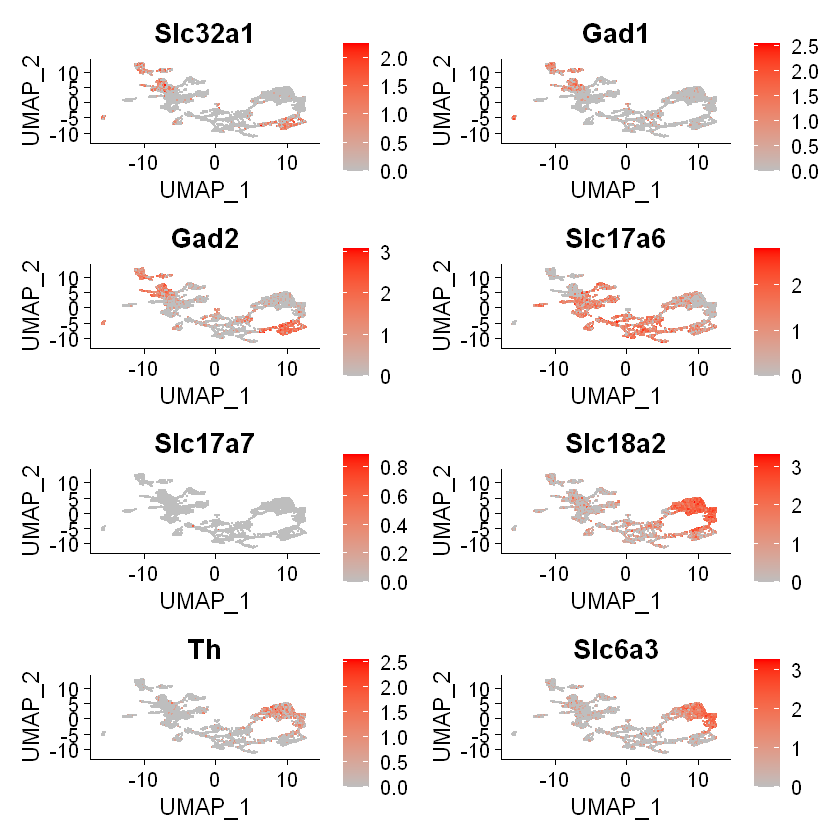

In [17]:
F<-FeaturePlot(object =VTA.integrated, features = c("Slc32a1","Gad1","Gad2","Slc17a6","Slc17a7","Slc18a2","Th","Slc6a3"), ncol=2, cols=c("gray","red"))
F


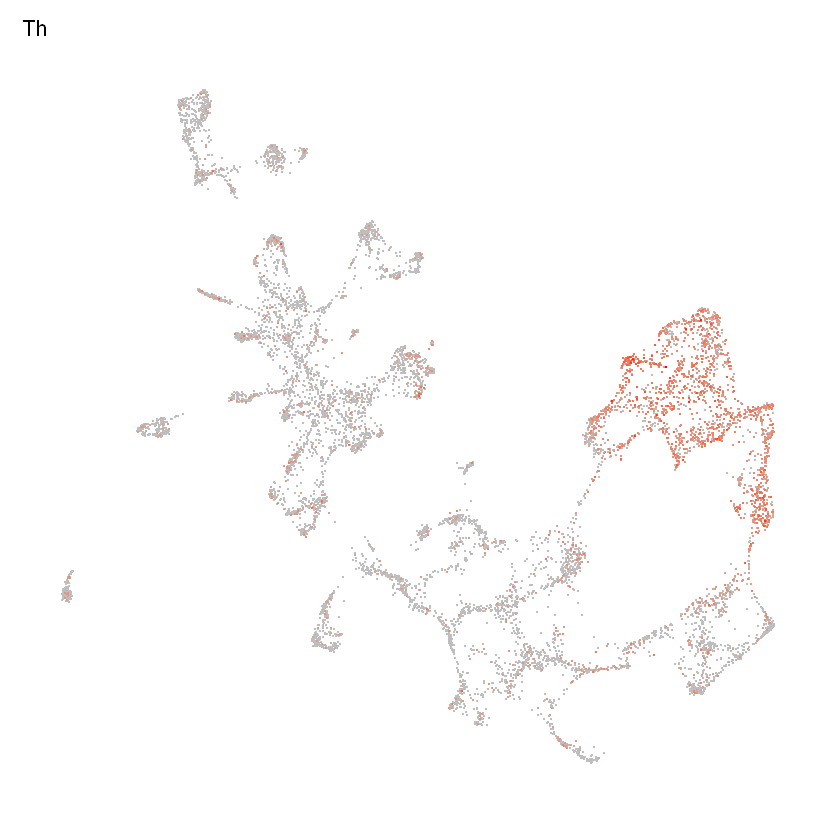

In [18]:
# Nice formatting
F <- FeaturePlot(object =VTA.integrated, features = c("Th"), cols=c("gray","red"), pt.size=.1, ncol=1, order=TRUE)+
theme_classic()+
theme(axis.line=element_blank(),
      axis.ticks=element_blank(),
       axis.text=element_blank(),
     axis.title=element_blank())+
NoLegend()
F

## Checking data quality

#### Cell counts in each cluster

In [19]:
Cells_in_clusters <- as.data.frame(table(Idents(VTA.integrated)))

In [20]:
colnames(Cells_in_clusters)[1] <- "Cluster"
colnames(Cells_in_clusters)[2] <- "Number"

In [21]:
Cells_in_clusters$Cluster <- factor(Cells_in_clusters$Cluster, levels = c("Glu4","Glu1","Glu2","Glu7","Glu6","Glu3","Glu5","Gaba2","Gaba1","Gaba4","CoEx3","CoEx2","DA3","DA1","DA2","CoEx1","Gaba3"))

Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."


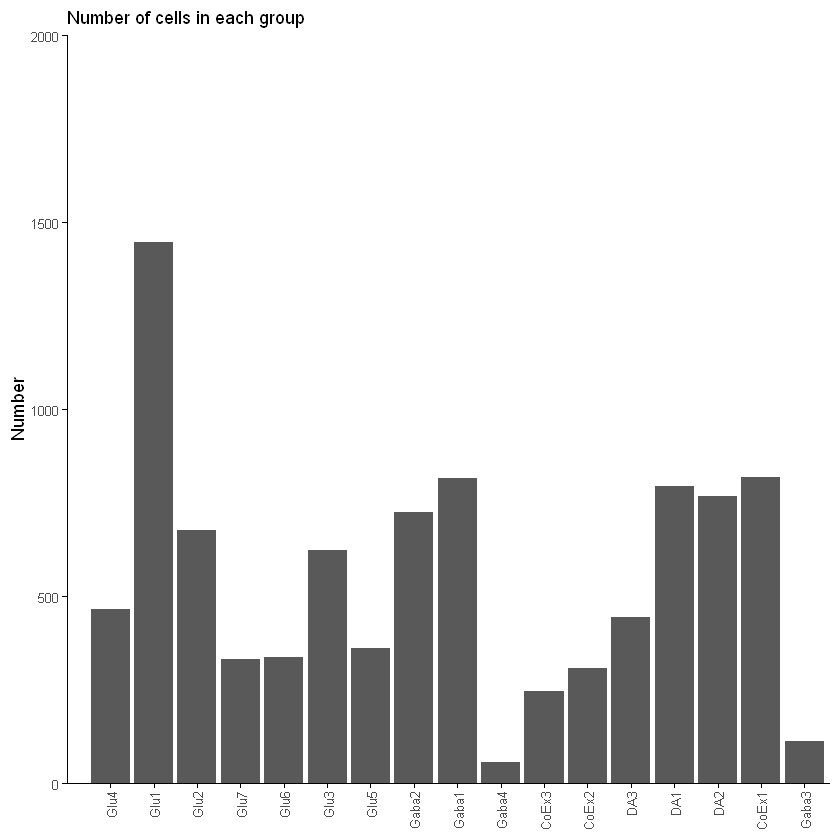

In [22]:
#group.colors <- c(LS_sal="#23bbef",LS_mor="#fc8b84", LS_nal="#21d936")
p <- ggplot(data=Cells_in_clusters, aes (x=Cluster, y=Number)) +
geom_bar(stat="identity", position="identity") +
scale_y_continuous(breaks = seq(0, 2000, by = 500), limits=c(0,2000), expand = c(0, 0))+
theme_classic() +
theme(axis.line = element_line(color="black",size=0.1), axis.title.x= element_blank(), axis.text.y=element_text(size=8) ,axis.text.x=element_text(angle = 90, vjust=0.5, hjust = 1, size=8, ) ,plot.title=element_text(size=11)) +
theme(legend.title = element_text(size = 10),legend.text = element_text(size = 8), axis.ticks = element_line(colour = "black", size = .25), axis.line = element_line(colour = 'black', size = .25))+
ggtitle("Number of cells in each group") +
expand_limits(x = 0, y = 0) 
#scale_fill_manual(values=group.colors)
p

#### Mito reads vs UMIs

In [23]:
mito.features <- grep(pattern = "^mt-", x = rownames(x =VTA.integrated), value = TRUE)
percent.mito <- Matrix::colSums(x = GetAssayData(object = VTA.integrated, slot = 'counts')[mito.features, ]) / Matrix::colSums(x = GetAssayData(object = VTA.integrated, slot = 'counts'))*100
VTA.integrated[['percent.mito']] <- percent.mito

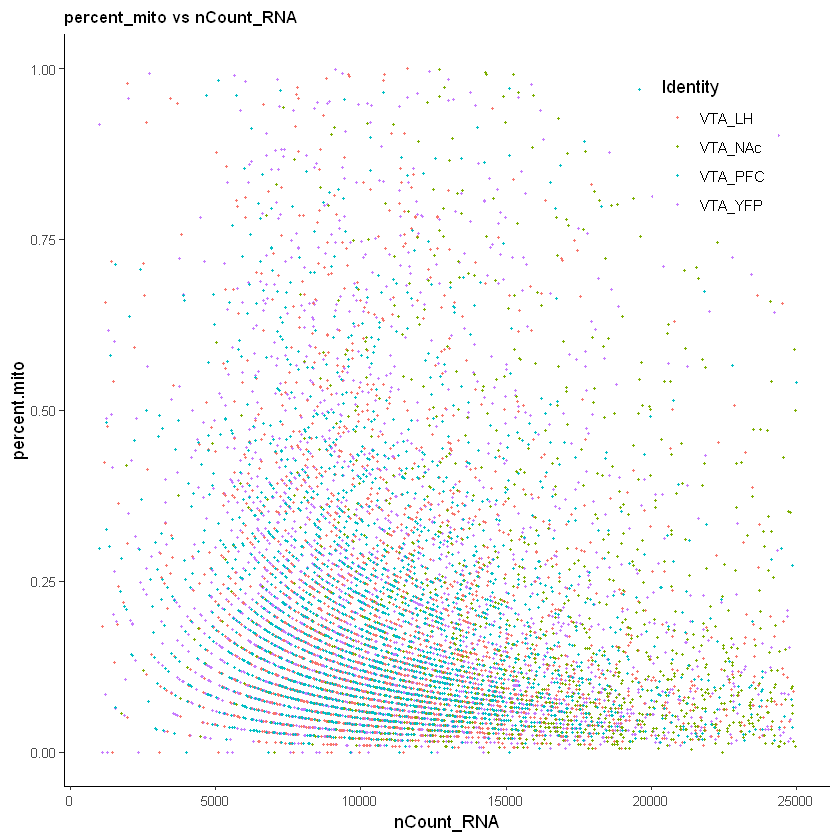

In [24]:
FeatureScatter(VTA.integrated,feature1 = "nCount_RNA", feature2 = "percent.mito", group.by="stim", pt.size=0.5) + theme_classic() + 
ggtitle("percent_mito vs nCount_RNA") +
theme(legend.position=c(0.85,0.85)) +
theme(axis.line = element_line(color="black",size=0.1), axis.text.y=element_text(size=8), axis.text.x=element_text(size=8),
      plot.title=element_text(size=10, face="bold"), axis.ticks = element_line(size=0.25),
      #panel.background = element_rect(colour = "black", size=.5, fill=NA)
     ) 

Warning message:
"Removed 6127 rows containing missing values (`geom_point()`)."


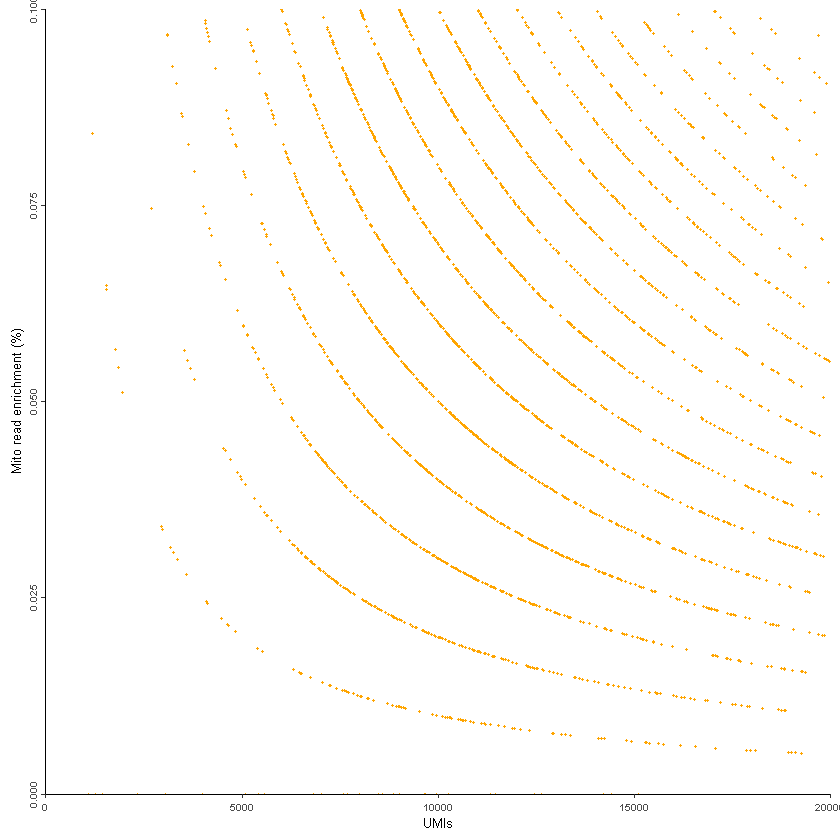

In [25]:
nCounts <- VTA.integrated@meta.data$nCount_RNA
nFeatures <- VTA.integrated@meta.data$nFeature_RNA
mito <- VTA.integrated@meta.data$percent.mito

all <- data.frame(counts = nCounts, features = nFeatures, percent.mito = mito)

ggplot(all, aes(x = nCounts, y = percent.mito)) +
    geom_point(color="orange", size=0.5) +
    theme_classic()+
     theme(axis.line=element_line(size=0.25),
         axis.ticks=element_line(size=0.25),
         axis.text=element_text(size=6),
           axis.text.y=element_text(angle=90, hjust=0.5),
         axis.title=element_text(size=8))+
    scale_x_continuous(expand = c(0, 0), limits=c(0,20000)) + 
    scale_y_continuous(expand = c(0, 0), limits=c(0,0.1))+
    xlab("UMIs")+
    ylab("Mito read enrichment (%)")


In [26]:
RNA <- ggplot(all, aes(x = "nCounts",y=nCounts)) +
    geom_violin(fill="orange", size=0.25) +
    theme_classic() +
    stat_summary(fun.y=median, geom="point", size=1, color="white") +
    theme(axis.line=element_line(size=0.25),
         axis.ticks=element_line(size=0.25),
         axis.text=element_text(size=6),
         axis.title=element_text(size=8),
         axis.title.x=element_blank(),
         axis.text.y=element_text(angle=90, hjust=.5))+
        ylim(c(0,20000)) +
        ylab("UMI counts") +
        xlab("Neurons only")

Genes <- ggplot(all, aes(x = "nFeatures",y=nFeatures)) +
    geom_violin(fill="orange", size=0.25) +
    theme_classic() +
    stat_summary(fun.y=median, geom="point", size=1, color="white") +
    theme(axis.line=element_line(size=0.25),
         axis.ticks=element_line(size=0.25),
         axis.text=element_text(size=6),
         axis.title=element_text(size=8),
         axis.title.x=element_blank(),
         axis.text.y=element_text(angle=90, hjust=.5))+
        ylim(c(0,6000)) +
        ylab("Gene counts") +
        xlab("Neurons only")

Mito <- ggplot(all, aes(x = "percent mito",y=percent.mito)) +
    geom_violin(fill="orange", size=0.25) +
    theme_classic() +
    stat_summary(fun.y=median, geom="point", size=1, color="white") +
    theme(axis.line=element_line(size=0.25),
         axis.ticks=element_line(size=0.25),
         axis.text=element_text(size=6),
         axis.title=element_text(size=8),
         axis.title.x=element_blank(),
         axis.text.y=element_text(angle=90, hjust=.5))+
        ylim(c(0,0.10)) +
        ylab("Mito read enrichment (%)") +
        xlab("Neurons only")


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
i Please use `linewidth` instead."
Warning message:
"The `fun.y` argument of `stat_summary()` is deprecated as of ggplot2 3.3.0.
i Please use the `fun` argument instead."


Warning message:
"Removed 586 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 586 rows containing non-finite values (`stat_summary()`)."
Warning message:
"Removed 52 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 52 rows containing non-finite values (`stat_summary()`)."


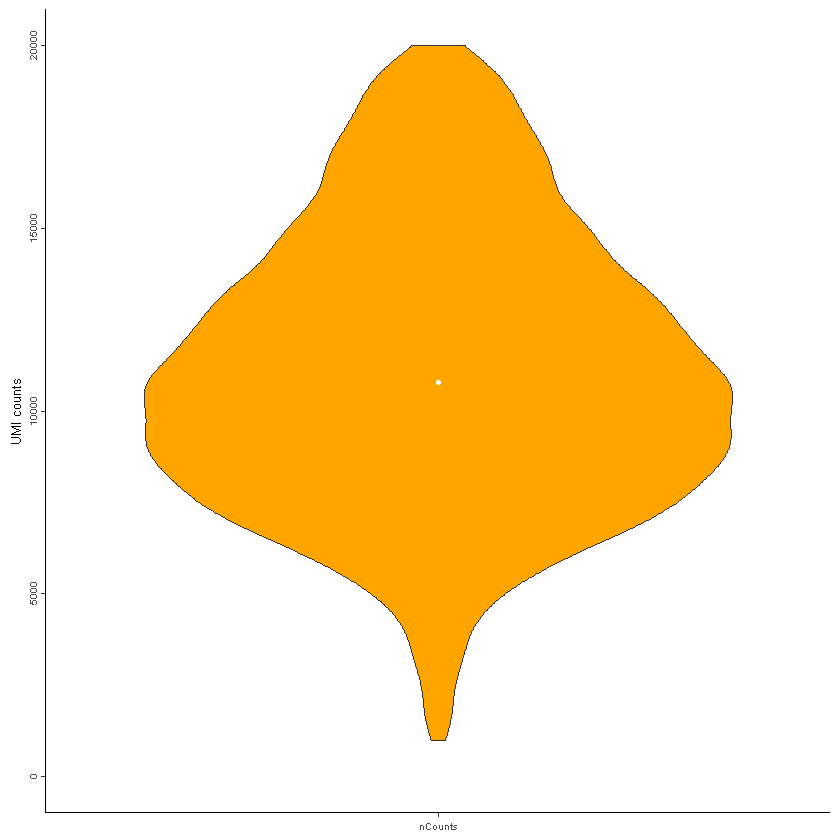

Warning message:
"Removed 5801 rows containing non-finite values (`stat_ydensity()`)."
Warning message:
"Removed 5801 rows containing non-finite values (`stat_summary()`)."


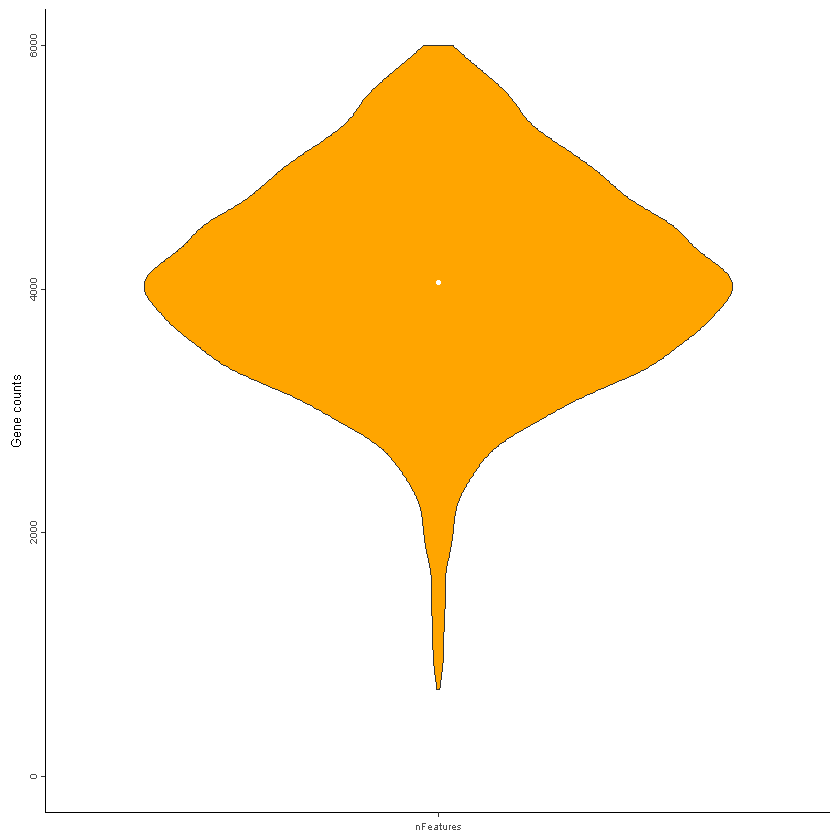

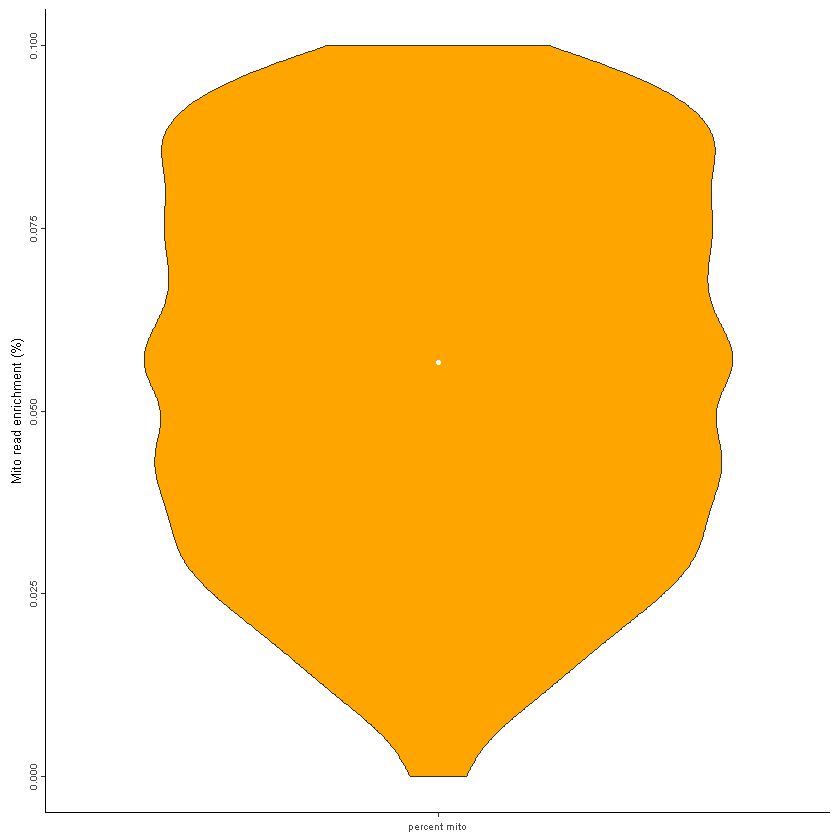

In [27]:
RNA
Genes
Mito

#### Proportion of cells in each group

In [28]:
subset <- as.data.frame(table(Idents(VTA.integrated)))
cluster_numbers<- subset[2]

In [29]:
subset <- rep(array(unlist(cluster_numbers)),4)

In [30]:
cluster_by_group <- as.data.frame(table(Idents(VTA.integrated), VTA.integrated$stim))
colnames(cluster_by_group) <- c("Cluster","Group","Cells")
cluster_by_group$Total <- subset

In [31]:
cluster_by_group <- transform(cluster_by_group, prop = Cells/Total)

In [32]:
cluster_by_group$Group <- factor(cluster_by_group$Group, levels = c("VTA_YFP","VTA_LH","VTA_PFC","VTA_NAc"), ordered=TRUE)
cluster_by_group$Cluster<-factor(cluster_by_group$Cluster, levels=c("DA1","DA2","DA3","Glu1","Glu2","Glu3","Glu4","Glu5","Glu6","Glu7","Gaba1","Gaba2","Gaba3","Gaba4","CoEx1",'CoEx2','CoEx3'))

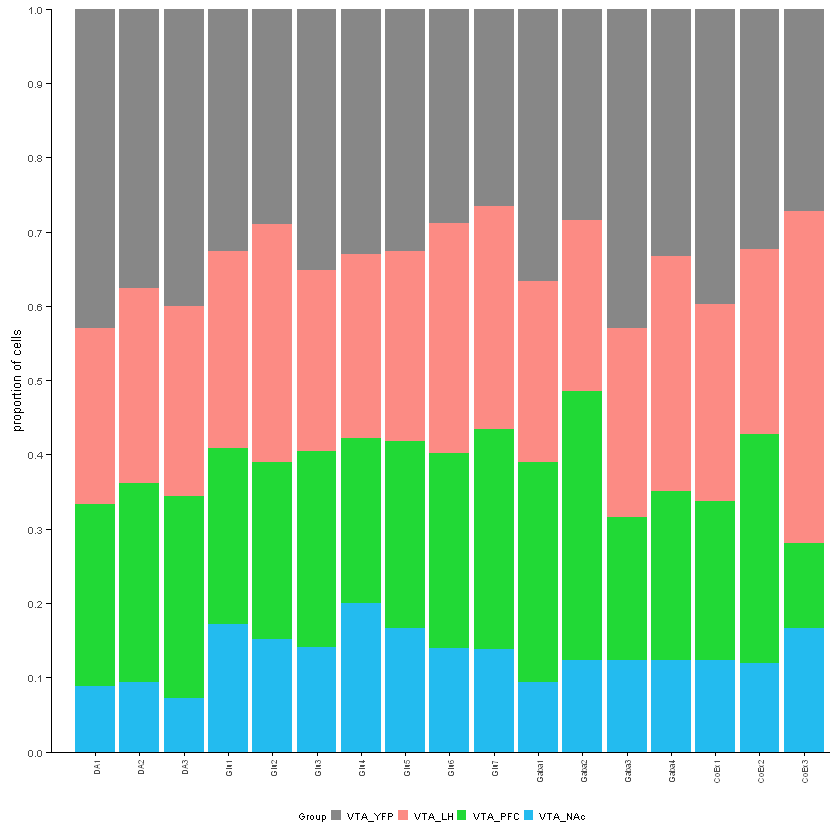

In [33]:
group.colors <- c(VTA_YFP="#878787",VTA_LH="#fc8b84", VTA_PFC="#21d936", VTA_NAc="#23bbef")
p <- ggplot(data=cluster_by_group, aes (x=Cluster, y=prop, fill=Group)) +
    geom_bar(stat="identity", position="stack") +
    scale_y_continuous(breaks = seq(0, 1, by = .1), limits=c(0,1), expand = c(0, 0))+
    theme_classic() +
    theme(axis.line = element_line(color="black",size=0.25), 
          axis.text.y=element_text(size=6),
          axis.title.x = element_blank(), 
          axis.title.y = element_text(size=8),
          axis.text.x=element_text(angle = 90, vjust=0.5, hjust = 1, size=5, ) ,
          plot.title=element_blank()) +
    theme(legend.position='bottom',
          legend.title = element_text(size = 6),
          legend.text = element_text(size = 6), 
          axis.ticks = element_line(colour = "black", size = .25), 
          axis.line = element_line(colour = 'black', size = .25),
         legend.key.size = unit(0.1, "in"))+
    ggtitle("Proportion of cells") +
    expand_limits(x = 0, y = 0) +
    scale_fill_manual(values=group.colors)+
    ylab("proportion of cells")

p

#### UMI and gene plots

In [34]:
wanted_col <- c("celltype","stim","nCount_RNA","nFeature_RNA")

In [35]:
subset <- as.data.frame(VTA.integrated@meta.data[,wanted_col])

In [36]:
col <- vector(mode="numeric", length=0)
for (i in 1:length(subset$celltype)){
    if (subset$stim[i]=="VTA_YFP"){col[i]<- "#878787"}
    else if (subset$stim[i]=="VTA_LH"){col[i]<- "#fc8b84"}
    else if (subset$stim[i]=="VTA_PFC"){col[i]<- "#21d936"}
    else if (subset$stim[i]=="VTA_PFC"){col[i]<- "#23bbef"}
}
subset$col <- col

In [37]:
subset$stim <- factor(subset$stim, levels=c("VTA_YFP","VTA_LH","VTA_NAc","VTA_PFC"))

In [38]:
subset$celltype <- factor(subset$celltype, levels=c("DA1","DA2","DA3","Glu1","Glu2","Glu3","Glu4","Glu5","Glu6","Glu7","Gaba1","Gaba2","Gaba3","Gaba4","CoEx1",'CoEx2','CoEx3'))

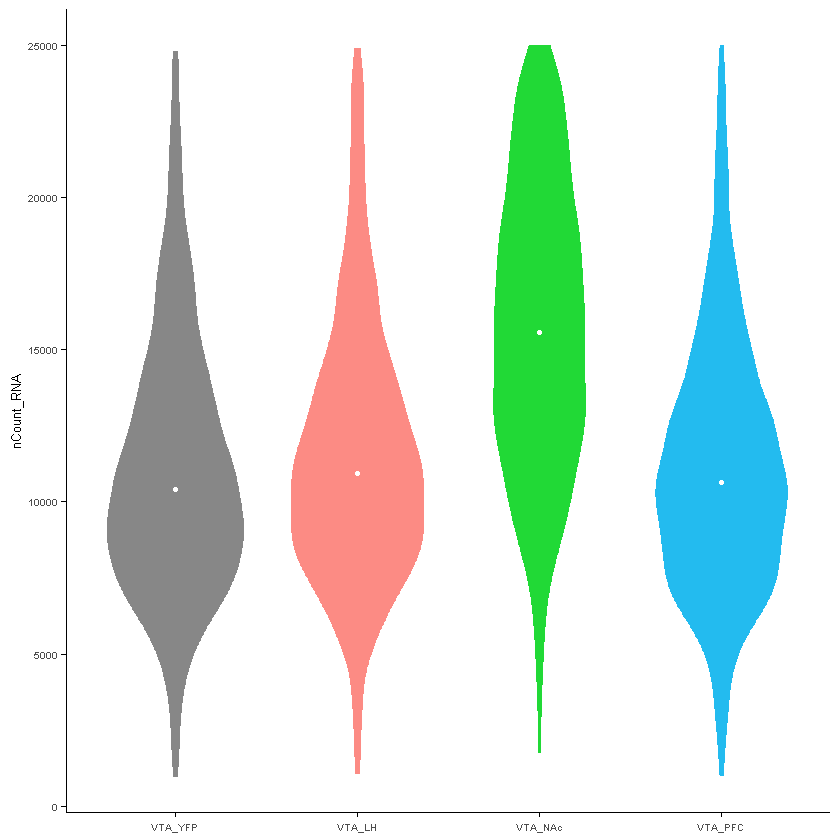

In [39]:
pu <- ggplot(subset, aes(x=stim, y=nCount_RNA, color=stim, fill=stim)) + 
    geom_violin(width=0.75, size=0.25) +
    stat_summary(fun.y=median, geom="point", size=1, color="white")+
    theme_classic()+
    theme(axis.line = element_line(color="black",size=0.1),
          axis.text.y=element_text(size=6) ,
          axis.text.x=element_text(vjust=0.5, size=6),
          axis.title.x=element_blank(),
          axis.title.y=element_text(size=8),
          plot.title=element_blank()) +
    theme(legend.title = element_text(size = 8),
          legend.text = element_text(size = 6), 
          axis.ticks = element_line(colour = "black", size = .25), 
          axis.line = element_line(colour = 'black', size = .25))+
    ggtitle("UMI counts by group") +
    scale_fill_manual(values = c("#878787", "#fc8b84","#21d936","#23bbef"))+
    scale_color_manual(values = c("#878787", "#fc8b84","#21d936","#23bbef"))+
    NoLegend()
pu


Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
i Please use the `linewidth` argument instead."
Warning message:
"`position_dodge()` requires non-overlapping x intervals"
Warning message:
"`position_dodge()` requires non-overlapping x intervals"
Warning message:
"`position_dodge()` requires non-overlapping x intervals"
Warning message:
"`position_dodge()` requires non-overlapping x intervals"


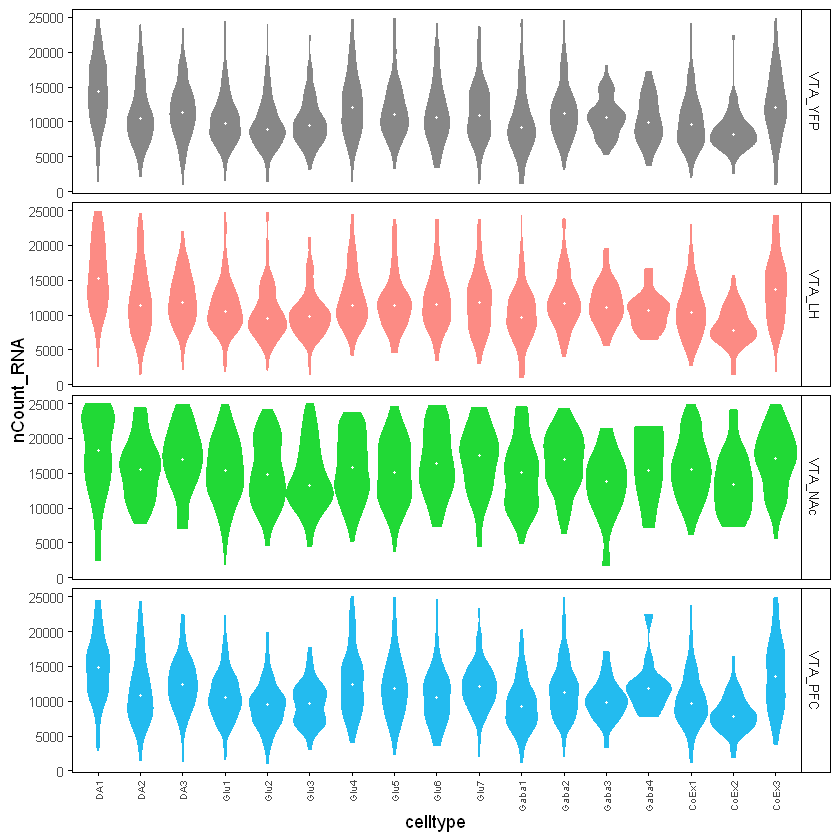

In [40]:
pu <- ggplot(subset, aes(x=celltype, y=nCount_RNA, fill=stim, color=stim)) + 
    geom_violin(width=1.1, size=0.25) +
    stat_summary(fun.y=median, geom="point", size=0.5, color="white")+
    theme_classic()+
    theme(axis.line = element_line(color="black",size=0.1),
          axis.text.y=element_text(size=8) ,
          axis.text.x=element_text(angle = 90, vjust=0.5, hjust = 1, size=6),
          plot.title=element_blank()) +
    theme(legend.title = element_text(size = 8),
          legend.text = element_text(size = 6), 
          axis.ticks = element_line(colour = "black", size = .25), 
          axis.line = element_line(colour = 'black', size = .25))+
    ggtitle("UMI counts by group") +
    scale_fill_manual(values = c("#878787", "#fc8b84","#21d936","#23bbef"))+
    scale_color_manual(values = c("#878787", "#fc8b84","#21d936","#23bbef"))

#pu
pu + facet_grid(rows = vars(subset$stim)) + NoLegend() +
theme(strip.background = element_rect(color="black", size=0.25, linetype="solid"), strip.text.y = element_text(size = 8),
      panel.background = element_rect(colour = "black", size=0.5, fill=NA))


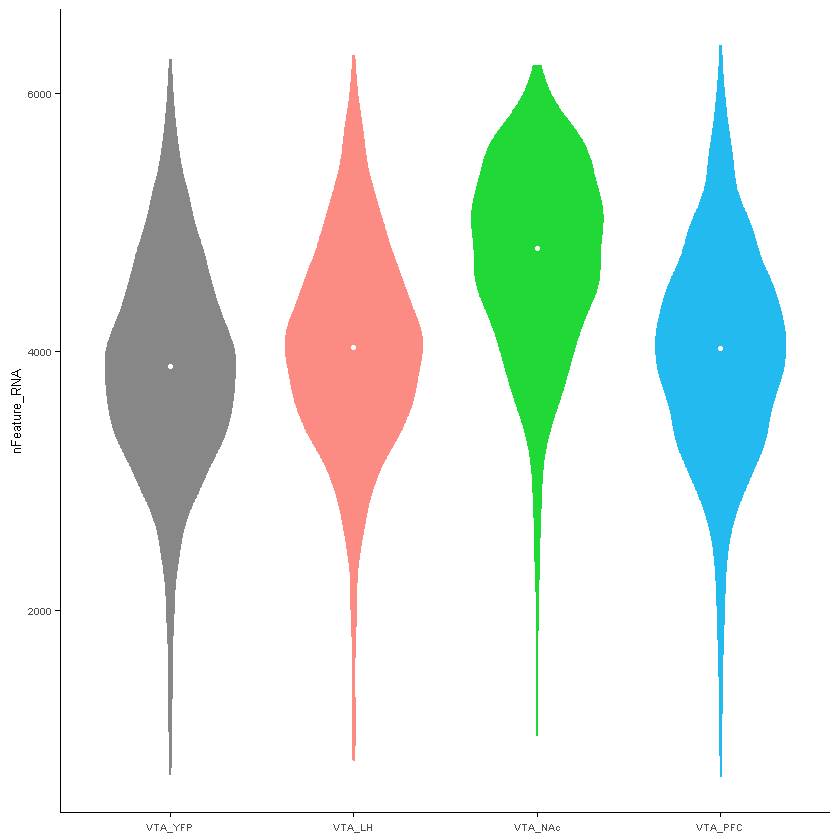

In [41]:
pg <- ggplot(subset, aes(x=stim, y=nFeature_RNA, color=stim, fill=stim)) + 
    geom_violin(width=0.75, size=0.25) +
    stat_summary(fun.y=median, geom="point", size=1, color="white")+
    theme_classic()+
    theme(axis.line = element_line(color="black",size=0.1),
           axis.title.x=element_blank(),
          axis.text.y=element_text(size=6) ,
            axis.title.y=element_text(size=8),
          axis.text.x=element_text( vjust=0.5, size=6),
          plot.title=element_blank()) +
    theme(legend.title = element_text(size = 8),
          legend.text = element_text(size = 6), 
          axis.ticks = element_line(colour = "black", size = .25), 
          axis.line = element_line(colour = 'black', size = .25))+
    ggtitle("Gene counts by group") +
    scale_fill_manual(values = c("#878787", "#fc8b84","#21d936","#23bbef"))+
    scale_color_manual(values = c("#878787", "#fc8b84","#21d936","#23bbef"))+
    NoLegend()
pg


Warning message:
"`position_dodge()` requires non-overlapping x intervals"
Warning message:
"`position_dodge()` requires non-overlapping x intervals"
Warning message:
"`position_dodge()` requires non-overlapping x intervals"
Warning message:
"`position_dodge()` requires non-overlapping x intervals"


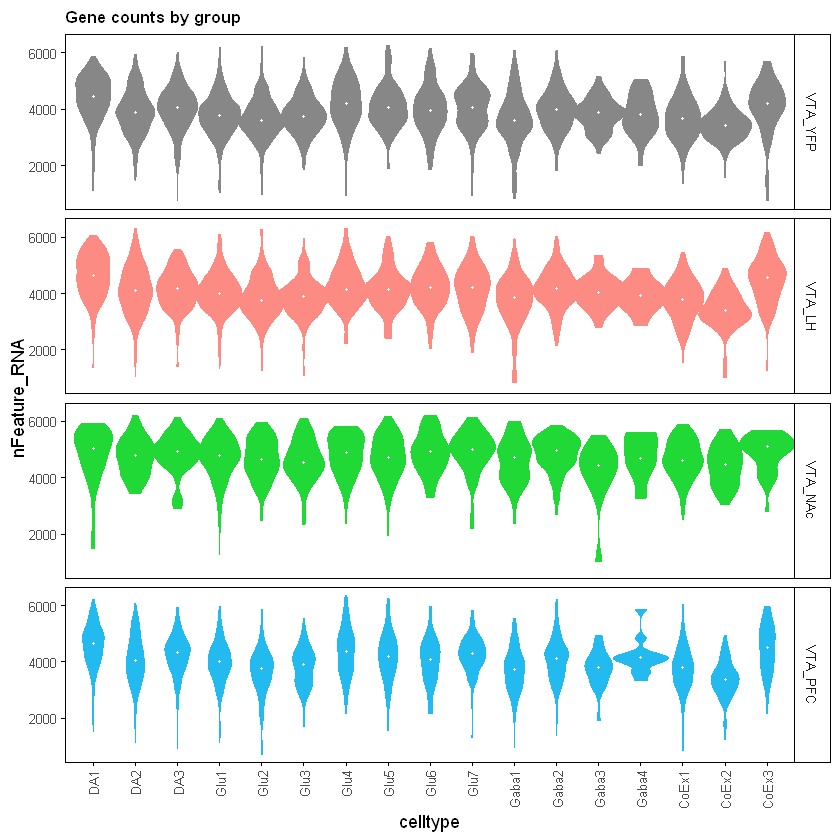

In [42]:
pg <- ggplot(subset, aes(x=celltype, y=nFeature_RNA, fill=stim, color=stim,)) + 
geom_violin(width=1.3, size=0.25) +
stat_summary(fun.y=median, geom="point", size=0.5, color="white")+
theme_classic()+
theme(axis.line = element_line(color="black",size=0.1), axis.text.y=element_text(size=8) ,axis.text.x=element_text(angle = 90, vjust=0.5, hjust = 1, size=8) ,plot.title=element_text(size=10, face="bold")) +
theme(legend.title = element_text(size = 11),legend.text = element_text(size = 8), axis.ticks = element_line(colour = "black", size = .25), axis.line = element_line(colour = 'black', size = .25))+
ggtitle("Gene counts by group") +
scale_fill_manual(values = c("#878787", "#fc8b84","#21d936","#23bbef"))+
scale_color_manual(values = c("#878787", "#fc8b84","#21d936","#23bbef"))

pg + facet_grid(rows = vars(subset$stim)) + NoLegend() +
theme(strip.background = element_rect(color="black", size=0.25, linetype="solid"), strip.text.y = element_text(size = 8),
      panel.background = element_rect(colour = "black", size=.5, fill=NA))
#pg


#### UMI:Gene ratio graph

In [43]:
wanted_col <- c("celltype","nCount_RNA","nFeature_RNA")

In [44]:
subset <- as.data.frame(VTA.integrated@meta.data[,wanted_col])

In [45]:
subset$celltype <- factor(subset$celltype, levels=c("DA1","DA2","DA3","Glu1","Glu2","Glu3","Glu4","Glu5","Glu6","Glu7","Gaba1","Gaba2","Gaba3","Gaba4","CoEx1",'CoEx2','CoEx3'))

In [46]:
#remaking UMI and gene violin plots to grab median counts
pu <- ggplot(subset, aes(x=celltype, y=nCount_RNA)) + 
geom_violin(width=1.3, size=0.25) +
stat_summary(fun.y=median, geom="point", size=0.5, color="white")+
theme_classic()+
theme(axis.line = element_line(color="black",size=0.1), axis.text.y=element_text(size=8) ,axis.text.x=element_text(angle = 90, vjust=0.5, hjust = 1, size=8) ,plot.title=element_text(size=10, face="bold")) +
theme(legend.title = element_text(size = 11),legend.text = element_text(size = 8), axis.ticks = element_line(colour = "black", size = .25), axis.line = element_line(colour = 'black', size = .25))
#pu

pg <- ggplot(subset, aes(x=celltype, y=nFeature_RNA)) + 
geom_violin(width=1.3, size=0.25) +
stat_summary(fun.y=median, geom="point", size=0.5, color="white")+
theme_classic()+
theme(axis.line = element_line(color="black",size=0.1), axis.text.y=element_text(size=8) ,axis.text.x=element_text(angle = 90, vjust=0.5, hjust = 1, size=8) ,plot.title=element_text(size=10, face="bold")) +
theme(legend.title = element_text(size = 11),legend.text = element_text(size = 8), axis.ticks = element_line(colour = "black", size = .25), axis.line = element_line(colour = 'black', size = .25))
#pg

In [47]:
UMI_median <- as.data.frame(ggplot_build(pu)$data[[2]]$y)
colnames(UMI_median)[1] <- "UMI"
gene_median <- as.data.frame(ggplot_build(pg)$data[[2]]$y)
colnames(gene_median)[1] <- "Gene"

Warning message:
"`position_dodge()` requires non-overlapping x intervals"
Warning message:
"`position_dodge()` requires non-overlapping x intervals"


In [48]:
Cell_type <- as.data.frame(c("DA1","DA2","DA3","Glu1","Glu2","Glu3","Glu4","Glu5","Glu6","Glu7","Gaba1","Gaba2","Gaba3","Gaba4","CoEx1",'CoEx2','CoEx3'))
colnames(Cell_type)[1] <- "Cluster"

In [49]:
stat_table <- cbind(Cell_type,UMI_median,gene_median)
stat_table$ratio <- stat_table$UMI / stat_table$Gene

In [50]:
stat_table$Cluster <- factor(stat_table$Cluster, levels=c("DA1","DA2","DA3","Glu1","Glu2","Glu3","Glu4","Glu5","Glu6","Glu7","Gaba1","Gaba2","Gaba3","Gaba4","CoEx1",'CoEx2','CoEx3'))

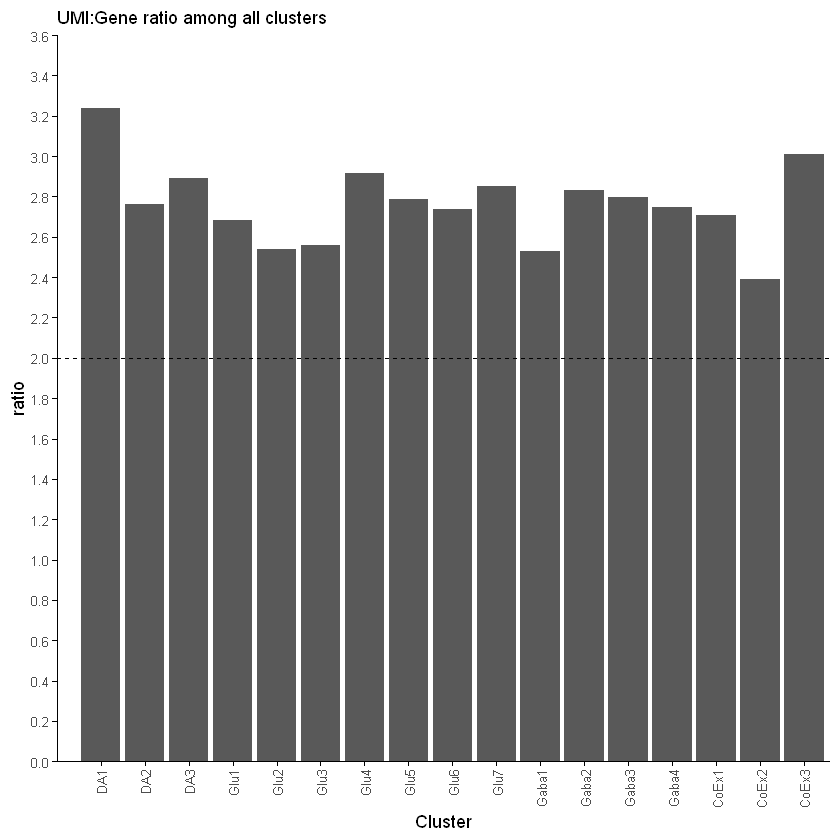

In [51]:
p <- ggplot(data=stat_table, aes (x=Cluster, y=ratio)) +
geom_bar(stat="identity", position="identity") +
scale_y_continuous(breaks = seq(0, 3.6, by = 0.2), limits=c(0,3.6), expand = c(0, 0))+
geom_hline(yintercept=2, linetype="dashed", size=0.25)+
theme_classic() +
theme(axis.line = element_line(color="black",size=0.1), panel.grid.major = element_blank(), panel.grid.minor = element_blank(), axis.text.y=element_text(size=8) ,axis.text.x=element_text(angle = 90, vjust=0.5, hjust = 1, size=8, ) ,plot.title=element_text(size=11)) +
theme(legend.title = element_text(size = 11),legend.text = element_text(size = 8), axis.ticks = element_line(colour = "black", size = .25), axis.line = element_line(colour = 'black', size = .25))+
ggtitle("UMI:Gene ratio among all clusters") +
expand_limits(x = 0, y = 0) 
p



# violin plot

In [52]:
DefaultAssay(VTA.integrated) <- "RNA"

In [53]:
levels(VTA.integrated) <- ((c("DA1","DA2","DA3","Gaba1","Gaba2","Gaba3","Gaba4","Glu1","Glu2","Glu3","Glu4","Glu5","Glu6","Glu7","CoEx1","CoEx2","CoEx3")))

In [54]:
gene_list <- c("Th","Slc6a3","Slc18a2","Gad1","Gad2","Slc32a1","Slc17a6","Slc17a7")

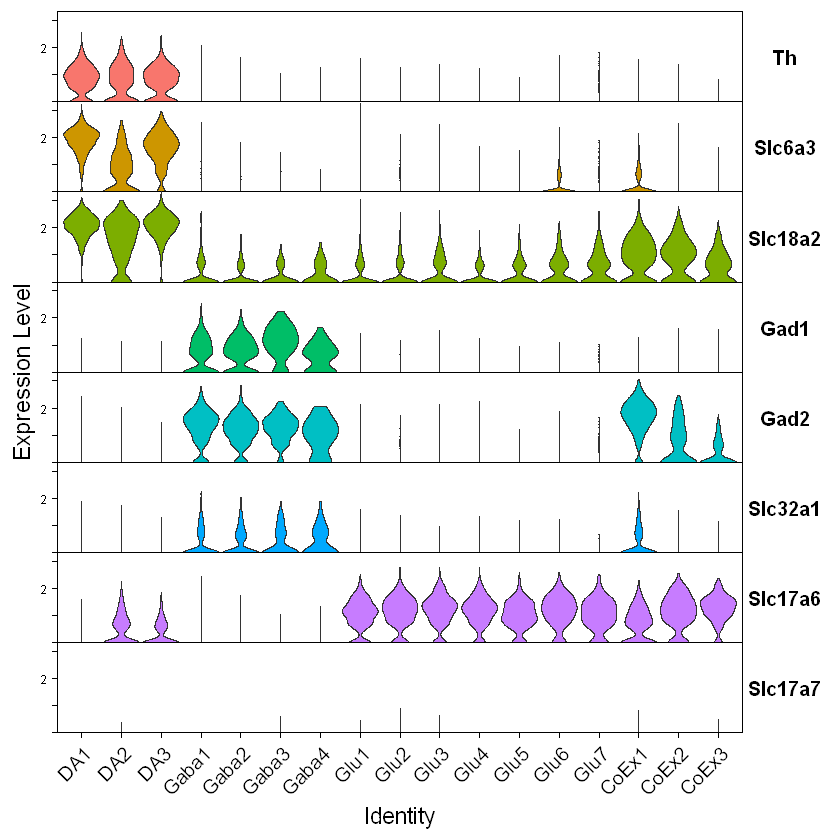

In [55]:
a <- VlnPlot(VTA.integrated, gene_list, stack = TRUE, flip = TRUE, same.y.lims = TRUE) + # +  id=c('DA1','DA2','DA3')
        theme(legend.position = "none")

# Use plot_grid to join plots
plot_grid(a)

# disc plot

In [56]:
DefaultAssay(VTA.integrated) <- "RNA"

In [57]:
levels(VTA.integrated) <- ((c("Gaba3","CoEx1","DA2","DA1","DA3","CoEx3","CoEx2","Gaba4","Gaba1","Gaba2","Glu5","Glu3","Glu6","Glu7","Glu2","Glu1","Glu4")))

In [58]:
gene_list <- (c('Gad1','Gad2','Th','Slc17a6','Crhbp','Glra2','Ndnf','Cbln4','Sema3c','Slit2','Cdh23','Pnoc','Adamts2','Sema5b','Adcyap1'))

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


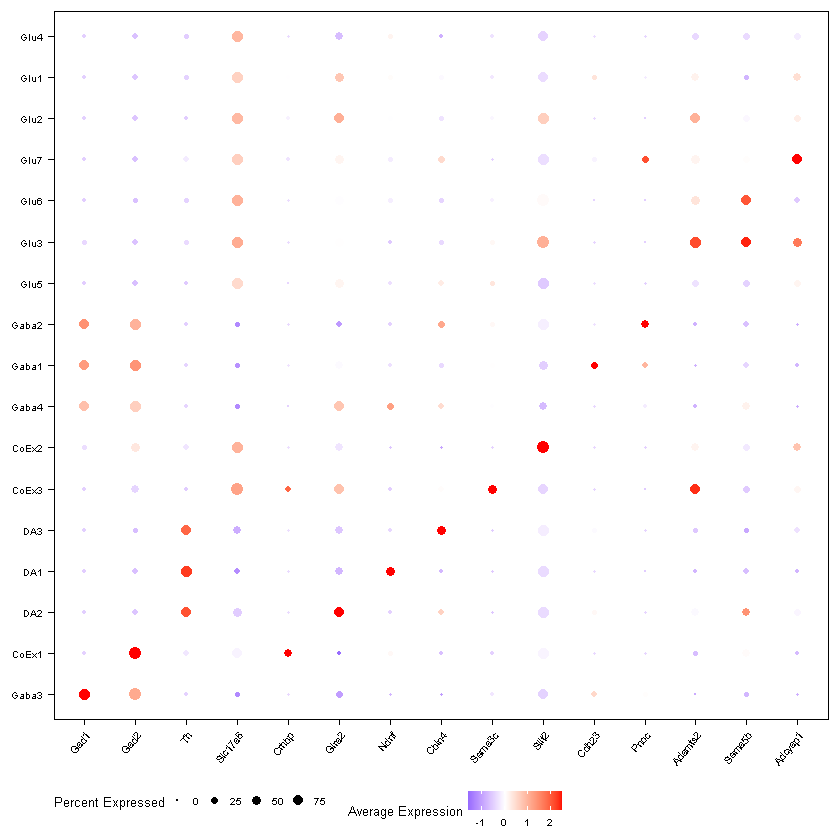

In [59]:
#three color
DotPlot(VTA.integrated, feature=gene_list, scale=TRUE) +  #, id=c('DA1','DA2','DA3')
scale_colour_gradient2(low = "blue", mid = "white", high = "red") +
theme(axis.title=element_blank(),
          axis.text.y=element_text(size=6,colour = "black"),
          axis.text.x=element_text(size=6,angle = 50, hjust =1,colour = "black"),
          axis.line = element_blank(),
          axis.ticks = element_line(size=0.25),
          legend.key.size = unit(0.4, "cm"),
          panel.background = element_rect(colour = "black", size=.25, fill=NA),
          legend.title = element_text(size=8),
          legend.text = element_text(size=6),
          legend.position='bottom') +
scale_size_continuous(range = c(0,3)) 
#coord_flip()


## Identifying conserved markers for each cluster

comparison between a particular cluster vs all other clusters

In [60]:
DefaultAssay(VTA.integrated) <- "RNA"

In [61]:
#conserved markers per cluster
Cell_type<-c("DA1","DA2","DA3","Glu1","Glu2","Glu3","Glu4","Glu5","Glu6","Glu7","Gaba1","Gaba2","Gaba3","Gaba4","CoEx1",'CoEx2','CoEx3')
for (i in 1:length(Cell_type)){
one.markers <- FindConservedMarkers(VTA.integrated, ident.1 = Cell_type[i], grouping.var = "stim",print.bar = FALSE, log2FC.threshold=0.01)
one.markers<-subset(one.markers,VTA_YFP_p_val_adj<0.05 & VTA_LH_p_val_adj<0.05 & VTA_NAc_p_val_adj<0.05 & VTA_PFC_p_val_adj<0.05 & VTA_YFP_avg_log2FC>0 & VTA_LH_avg_log2FC>0 & VTA_NAc_avg_log2FC>0 & VTA_PFC_avg_log2FC>0)
sort_marker<-one.markers[order(-one.markers["VTA_YFP_avg_log2FC"]),]
write.xlsx(sort_marker,file=(paste("./",Cell_type[i],"_gene.xlsx",sep="")))
}

Testing group VTA_NAc: (DA1) vs (Glu1, Glu5, Gaba4, Gaba1, Glu2, Gaba3, Glu7, Glu4, CoEx3, Glu6, Gaba2, Glu3, CoEx2, CoEx1, DA2, DA3)

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Testing group VTA_PFC: (DA1) vs (Gaba1, Glu1, Glu5, Glu4, Glu7, Gaba4, Glu2, CoEx1, Gaba3, CoEx3, Gaba2, Glu6, Glu3, DA3, CoEx2, DA2)

Testing group VTA_LH: (DA1) vs (Glu1, Gaba1, Glu5, Glu4, Glu7, Glu2, Gaba3, Glu6, Gaba2, CoEx3, Gaba4, DA3, Glu3, CoEx2, CoEx1, DA2)

Testing group VTA_YFP: (DA1) vs (DA2, Glu4, Glu7, Glu1, Glu5, Glu2, Gaba1, CoEx3, Gaba2, Gaba4, Gaba3, Glu3, CoEx1, DA3, CoEx2, Glu6)

Warnin

Warning message in xtfrm.data.frame(x):
"cannot xtfrm data frames"
Testing group VTA_NAc: (Gaba4) vs (Glu1, Glu5, Gaba1, Glu2, Gaba3, Glu7, Glu4, CoEx3, Glu6, Gaba2, Glu3, CoEx2, CoEx1, DA2, DA1, DA3)

Testing group VTA_PFC: (Gaba4) vs (Gaba1, Glu1, Glu5, Glu4, Glu7, Glu2, CoEx1, Gaba3, CoEx3, Gaba2, Glu6, Glu3, DA3, CoEx2, DA2, DA1)

Testing group VTA_LH: (Gaba4) vs (Glu1, Gaba1, Glu5, Glu4, Glu7, Glu2, Gaba3, Glu6, Gaba2, CoEx3, DA1, DA3, Glu3, CoEx2, CoEx1, DA2)

Testing group VTA_YFP: (Gaba4) vs (DA2, Glu4, Glu7, Glu1, Glu5, Glu2, Gaba1, CoEx3, Gaba2, Gaba3, Glu3, CoEx1, DA3, CoEx2, Glu6, DA1)

Warning message in xtfrm.data.frame(x):
"cannot xtfrm data frames"
Testing group VTA_NAc: (CoEx1) vs (Glu1, Glu5, Gaba4, Gaba1, Glu2, Gaba3, Glu7, Glu4, CoEx3, Glu6, Gaba2, Glu3, CoEx2, DA2, DA1, DA3)

Testing group VTA_PFC: (CoEx1) vs (Gaba1, Glu1, Glu5, Glu4, Glu7, Gaba4, Glu2, Gaba3, CoEx3, Gaba2, Glu6, Glu3, DA3, CoEx2, DA2, DA1)

Testing group VTA_LH: (CoEx1) vs (Glu1, Gaba1, Glu5, Glu4

plotting a conserved marker heatmap

In [71]:
#Read in conserved marker files
Gaba1<-read.xlsx2(file="./Gaba1_gene.xlsx",sheetIndex=1)
Gaba1$VTA_YFP_avg_log2FC<-as.numeric(paste(Gaba1$VTA_YFP_avg_log2FC))
Gaba1<-subset(Gaba1,VTA_YFP_avg_log2FC > 0.1)

Gaba2<-read.xlsx2(file="./Gaba2_gene.xlsx",sheetIndex=1)
Gaba2$VTA_YFP_avg_log2FC<-as.numeric(paste(Gaba2$VTA_YFP_avg_log2FC))
Gaba2<-subset(Gaba2,VTA_YFP_avg_log2FC > 0.1)

Gaba3<-read.xlsx2(file="./Gaba3_gene.xlsx",sheetIndex=1)
Gaba3$VTA_YFP_avg_log2FC<-as.numeric(paste(Gaba3$VTA_YFP_avg_log2FC))
Gaba3<-subset(Gaba3,VTA_YFP_avg_log2FC > 0.1)

Gaba4<-read.xlsx2(file="./Gaba4_gene.xlsx",sheetIndex=1)
Gaba4$VTA_YFP_avg_log2FC<-as.numeric(paste(Gaba4$VTA_YFP_avg_log2FC))
Gaba4<-subset(Gaba4,VTA_YFP_avg_log2FC > 0.1)

DA1<-read.xlsx2(file="./DA1_gene.xlsx",sheetIndex=1)
DA1$VTA_YFP_avg_log2FC<-as.numeric(paste(DA1$VTA_YFP_avg_log2FC))
DA1<-subset(DA1,VTA_YFP_avg_log2FC > 0.1)

DA2<-read.xlsx2(file="./DA2_gene.xlsx",sheetIndex=1)
DA2$VTA_YFP_avg_log2FC<-as.numeric(paste(DA2$VTA_YFP_avg_log2FC))
DA2<-subset(DA2,VTA_YFP_avg_log2FC > 0.1)

DA3<-read.xlsx2(file="./DA3_gene.xlsx",sheetIndex=1)
DA3$VTA_YFP_avg_log2FC<-as.numeric(paste(DA3$VTA_YFP_avg_log2FC))
DA3<-subset(DA3,VTA_YFP_avg_log2FC > 0.1)

Glu1<-read.xlsx2(file="./Glu1_gene.xlsx",sheetIndex=1)
Glu1$VTA_YFP_avg_log2FC<-as.numeric(paste(Glu1$VTA_YFP_avg_log2FC))
Glu1<-subset(Glu1,VTA_YFP_avg_log2FC > 0.1)

Glu2<-read.xlsx2(file="./Glu2_gene.xlsx",sheetIndex=1)
Glu2$VTA_YFP_avg_log2FC<-as.numeric(paste(Glu2$VTA_YFP_avg_log2FC))
Glu2<-subset(Glu2,VTA_YFP_avg_log2FC > 0.1)

Glu3<-read.xlsx2(file="./Glu3_gene.xlsx",sheetIndex=1)
Glu3$VTA_YFP_avg_log2FC<-as.numeric(paste(Glu3$VTA_YFP_avg_log2FC))
Glu3<-subset(Glu3,VTA_YFP_avg_log2FC > 0.1)

Glu4<-read.xlsx2(file="./Glu4_gene.xlsx",sheetIndex=1)
Glu4$VTA_YFP_avg_log2FC<-as.numeric(paste(Glu4$VTA_YFP_avg_log2FC))
Glu4<-subset(Glu4,VTA_YFP_avg_log2FC > 0.1)

Glu5<-read.xlsx2(file="./Glu5_gene.xlsx",sheetIndex=1)
Glu5$VTA_YFP_avg_log2FC<-as.numeric(paste(Glu5$VTA_YFP_avg_log2FC))
Glu5<-subset(Glu5,VTA_YFP_avg_log2FC > 0.1)

Glu6<-read.xlsx2(file="./Glu6_gene.xlsx",sheetIndex=1)
Glu6$VTA_YFP_avg_log2FC<-as.numeric(paste(Glu6$VTA_YFP_avg_log2FC))
Glu6<-subset(Glu6,VTA_YFP_avg_log2FC > 0.1)

Glu7<-read.xlsx2(file="./Glu7_gene.xlsx",sheetIndex=1)
Glu7$VTA_YFP_avg_log2FC<-as.numeric(paste(Glu7$VTA_YFP_avg_log2FC))
Glu7<-subset(Glu7,VTA_YFP_avg_log2FC > 0.1)

CoEx1<-read.xlsx2(file="./CoEx1_gene.xlsx",sheetIndex=1)
CoEx1$VTA_YFP_avg_log2FC<-as.numeric(paste(Coex1$VTA_YFP_avg_log2FC))
CoEx1<-subset(Coex1,VTA_YFP_avg_log2FC > 0.1)

CoEx2<-read.xlsx2(file="./CoEx2_gene.xlsx",sheetIndex=1)
CoEx2$VTA_YFP_avg_log2FC<-as.numeric(paste(Coex2$VTA_YFP_avg_log2FC))
CoEx2<-subset(Coex2,VTA_YFP_avg_log2FC > 0.1)

CoEx3<-read.xlsx2(file="./CoEx3_gene.xlsx",sheetIndex=1)
CoEx3$VTA_YFP_avg_log2FC<-as.numeric(paste(Coex3$VTA_YFP_avg_log2FC))
CoEx3<-subset(Coex3,VTA_YFP_avg_log2FC > 0.1)

In [72]:
gene_list <- c(as.character(Gaba3$X.), as.character(CoEx1$X.), as.character(DA2$X.), as.character(DA1$X.), as.character(DA3$X.), as.character(CoEx2$X.), as.character(CoEx3$X.), as.character(Gaba4$X.), as.character(Gaba1$X.), as.character(Gaba2$X.), as.character(Glu5$X.), as.character(Glu3$X.), as.character(Glu6$X.), as.character(Glu7$X.), as.character(Glu2$X.), as.character(Glu1$X.),as.character(Glu4$X.))
gene_list <- unique(gene_list)

In [78]:
Cell_type<-c("Gaba3","CoEx1","DA2","DA1","DA3","CoEx2","CoEx3","Gaba4","Gaba1","Gaba2","Glu5","Glu3","Glu6","Glu7","Glu2","Glu1","Glu4")
Cell_type<-factor((Cell_type),levels=c("Gaba3","CoEx1","DA2","DA1","DA3","CoEx2","CoEx3","Gaba4","Gaba1","Gaba2","Glu5","Glu3","Glu6","Glu7","Glu2","Glu1","Glu4"))

In [79]:
Cell_number<- data.frame(Date=as.Date(character()),File=character(),User=character(),stringsAsFactors=FALSE)

for (i in 1:length(gene_list)){
L<-length(Cell_type)

    
Cell_number_t<- data.frame("cluster" =Cell_type, "gene"=(rep(gene_list[i],L))) # do not use c if the gene is factorizsed
#used normalized uncorrected data
for (p in 1:length(Cell_type)){
#Cell_number_t$pct[p]<-100*sum(VTA.integrated@assays$RNA@data[gene_list[i],eval(parse(text=paste(Cell_type[p],"_barcode",sep="")))]>0)/length(eval(parse(text=paste(Cell_type[p],"_barcode",sep=""))))
Cell_number_t$zscore[p]<-(mean(VTA.integrated@assays$RNA@data[gene_list[i],rownames(subset(VTA.integrated@meta.data,celltype==Cell_type[p]))])-mean(VTA.integrated@assays$RNA@data[gene_list[i],]))/sd(VTA.integrated@assays$RNA@data[gene_list[i],])
Cell_number_t$FC[p]<-mean(VTA.integrated@assays$RNA@data[gene_list[i],rownames(subset(VTA.integrated@meta.data,celltype==Cell_type[p]))])-mean(VTA.integrated@assays$RNA@data[gene_list[i],rownames(subset(VTA.integrated@meta.data,celltype!=Cell_type[p]))])
    }
Cell_number<-rbind(Cell_number_t,Cell_number)}
as.factor(Cell_number$cluster)

[1] Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3 
   [13] Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3
   [25] Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1
   [37] DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7 
   [49] Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1
   [61] Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1  
   [73] DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1 
   [85] Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5 
   [97] Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2
  [109] CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3
  [121] CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6 
  [133] Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4
  [145] Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2  
  [157] DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2 
  [169] Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2
  [181] Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3  
  [193] CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4 
  [205] Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3 
  [217] Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3
  [229] Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1
  [241] DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7 
  [253] Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1
  [265] Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1  
  [277] DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1 
  [289] Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5 
  [301] Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2
  [313] CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3
  [325] CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6 
  [337] Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4
  [349] Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2  
  [361] DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2 
  [373] Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2
  [385] Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3  
  [397] CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4 
  [409] Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3 
  [421] Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3
  [433] Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1
  [445] DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7 
  [457] Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1
  [469] Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1  
  [481] DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1 
  [493] Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5 
  [505] Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2
  [517] CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3
  [529] CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6 
  [541] Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4
  [553] Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2  
  [565] DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2 Glu5  Glu3  Glu6  Glu7  Glu2 
  [577] Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3   CoEx2 CoEx3 Gaba4 Gaba1 Gaba2
  [589] Glu5  Glu3  Glu6  Glu7  Glu2  Glu1  Glu4  Gaba3 CoEx1 DA2   DA1   DA3  
  [6

In [80]:
Cell_number$cluster<-factor(Cell_number$cluster,levels=rev(c("Gaba3","CoEx1","DA2","DA1","DA3","CoEx2","CoEx3","Gaba4","Gaba1","Gaba2","Glu5","Glu3","Glu6","Glu7","Glu2","Glu1","Glu4")))

In [81]:
Cell_number$gene<-factor(Cell_number$gene,levels=(gene_list))

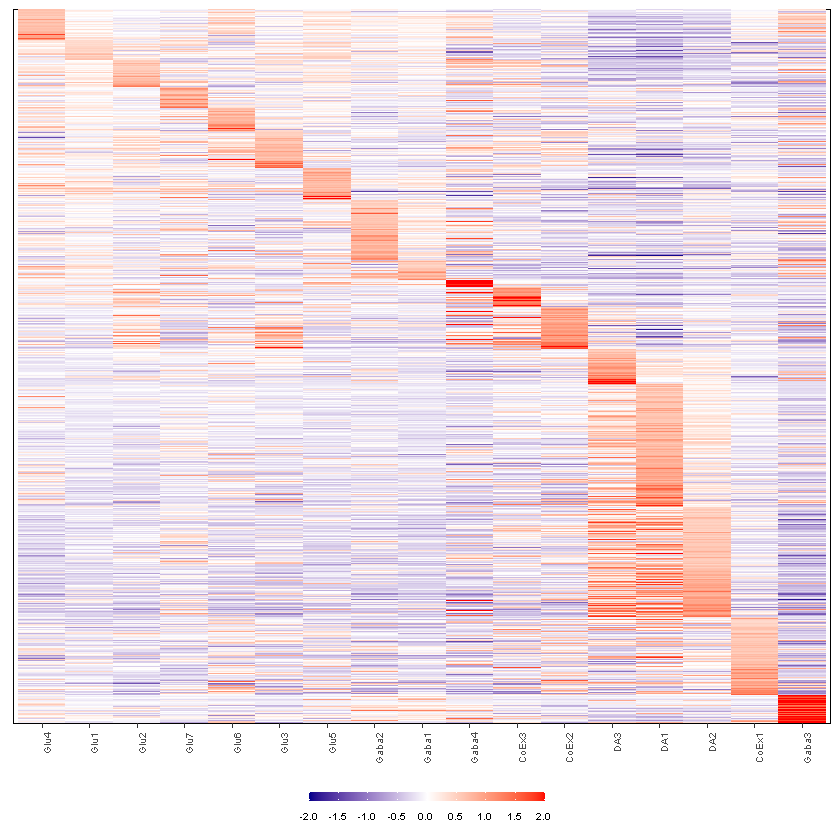

In [83]:
library(scales)
low<- -2
high<- 2
p<-ggplot(Cell_number, aes(gene, cluster))+ 
  geom_tile(aes(fill =zscore))+ scale_fill_gradient2(limits=c(low, high), breaks=seq(low,high,by=0.5),low = "darkblue",mid="white",midpoint=0,high = "red",oob=squish)
pp<-p+
theme_classic()+
theme(axis.text.x=element_text( size=6, angle=90, hjust=1),
            axis.text.y=element_blank(),
            plot.title = element_text(size=8),
            panel.background = element_rect(colour = "black", size=.25, fill=NA),
            axis.line.y = element_blank(),
            axis.line.x=element_blank(),
            axis.ticks.y = element_blank(),
            axis.title.y = element_blank(),
            axis.ticks.x = element_line(size=0.25),
            axis.title.x = element_blank(),
            legend.key.height= unit(0.2, 'cm'), 
            legend.key.width = unit(1.0, 'cm'),
            legend.position = "bottom",
            legend.text = element_text(size=6),
            legend.title = element_blank())+
coord_flip()
print(pp)